# LSTM for Time Series Prediction

This notebook illustrutes the time series prediction task using a Long Short Term Memory (LSTM) model implemented from scratch. 

The dataset used to train and evaluate the LSTM model is ......

In [278]:
import numpy as np
import pylab as plt
import jax
import jax.numpy as jnp
import re
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [279]:
%matplotlib inline
%load_ext autoreload
%autoreload 1
%aimport model.lstm
%aimport model.helper

from model.lstm import Lstm
from model.helper import mse

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data Processing

After downloading the raw data (of ... format), the [data processing notebook](/Taxi_data_processing.ipynb) is used to parse data, select and encode features, and generate training, validation, testing set for the model.

In [283]:
def generate_time_series_data(df, n_timesteps):
    X_train, Y_train = [], []
    for i in range(0, df.shape[0]):
        if i + 2 * n_timesteps < df.shape[0]:
            X = df[i: i + n_timesteps]
            Y = df[i + n_timesteps: i + 2 * n_timesteps]
            X_train.append(X)
            Y_train.append(Y)
    X_train, Y_train = jnp.array(X_train), jnp.array(Y_train)
    return X_train, Y_train


def processing_data(location=237, n_timesteps=50, train_val_ratio=0.8):
    # load preprocessed data
    df_train, df_test = pd.read_csv(f'data/parsed/train_data{location}.csv'), pd.read_csv(f'data/parsed/test_data{location}.csv')
    df_train['tpep_pickup_datetime'] = pd.to_datetime(df_train['tpep_pickup_datetime'])
    df_test['tpep_pickup_datetime'] = pd.to_datetime(df_test['tpep_pickup_datetime'])
    train_dates, test_dates = df_train['tpep_pickup_datetime'].to_numpy(), df_test['tpep_pickup_datetime'].to_numpy()
    df_train.drop(columns=['tpep_pickup_datetime', 'PULocationID'], inplace=True)
    df_test.drop(columns=['tpep_pickup_datetime', 'PULocationID'], inplace=True)
    
    # normalized data
    df_train =(df_train - df_train.mean()) / df_train.std()
    df_test =(df_test - df_test.mean()) / df_test.std()
    df_train, df_test = df_train.to_numpy(), df_test.to_numpy()

    # split train, validation, test set
    X, Y = generate_time_series_data(df_train, n_timesteps)
    X_test, Y_test = generate_time_series_data(df_test, n_timesteps)
    split_index = int(X.shape[0] * train_val_ratio)
    X_train, Y_train, X_val, Y_val = X[:split_index], Y[:split_index], X[split_index:], Y[split_index:]

    return train_dates, test_dates, X_train, Y_train, X_val, Y_val, X_test, Y_test  

## Model Training

The following cell initialize and runs the LSTM model on the processed data. 

In [284]:
n_timesteps = 50
num_features = 1
input_dim, hidden_dim, output_dim = num_features + 8, 8, 1
num_epoches = 100
learning_rate = 0.05
batch_size = 64

train_dates, test_dates, X_trains, Y_trains, X_vals, Y_vals, X_tests, Y_tests = [], [], [], [], [], [], [], []
Y_test_preds = []
for i, location in enumerate(['237', '161', '236']):
    print(f'------------------------- Location {location} -------------------------')
    train_date, test_date, X_train, Y_train, X_val, Y_val, X_test, Y_test = processing_data('237')
    train_dates.append(train_date)
    test_dates.append(test_date)
    X_trains.append(X_train)
    Y_trains.append(Y_train)
    X_vals.append(X_val)
    Y_vals.append(Y_val)
    X_tests.append(X_test)
    Y_tests.append(Y_test)
    model = Lstm(input_dim, hidden_dim, output_dim, num_epoches, learning_rate, batch_size)
    model.train(X_trains[i], Y_trains[i], X_vals[i], Y_vals[i])
    Y_test_pred = model.predict(X_tests[i])
    Y_test_preds.append(Y_test_pred)

------------------------- Location 237 -------------------------
Start training ...
Epoch 1/100: training loss = 0.3854195177555084 | validation loss = 0.36901211738586426
Epoch 11/100: training loss = 0.29346615076065063 | validation loss = 0.32209134101867676
Epoch 21/100: training loss = 0.28807950019836426 | validation loss = 0.3167683780193329


### Evaluation:

In [271]:
def visualize_time_series(Y_test, Y_test_pred):
    plt.figure(figsize=(10, 6))
    plt.plot(test_dates[:500], Y_test[:500], label='True pickup count (normalized)',color='blue', linestyle='-')
    plt.plot(test_dates[:500], Y_test_pred[:500], label='Predicted pickup count (normalized)',color='red', linestyle='-')
    plt.title('Time Series Plot of True and Predicted Taxi Pickup Count')
    plt.xlabel('Date')
    plt.ylabel('Pickup Count')
    plt.show()

for Y_test_pred, Y_test in zip(Y_test_preds, Y_tests):
    Y_test_pred_shifted = Y_test_pred[50:, 0, 0]
    Y_test_shifted = Y_test[:Y_test_pred_shifted.shape[0], 0, 0]
    print(Y_test_shifted.shape, Y_test_pred_shifted.shape)
    print(f'Model prediction MSE = {mse(Y_test_shifted[:, jnp.newaxis], Y_test_pred_shifted[:, jnp.newaxis])}')
    visualize_time_series(Y_test_shifted, Y_test_pred_shifted)

(6428,) (6428,)


### Evaluation 2: Line Plot

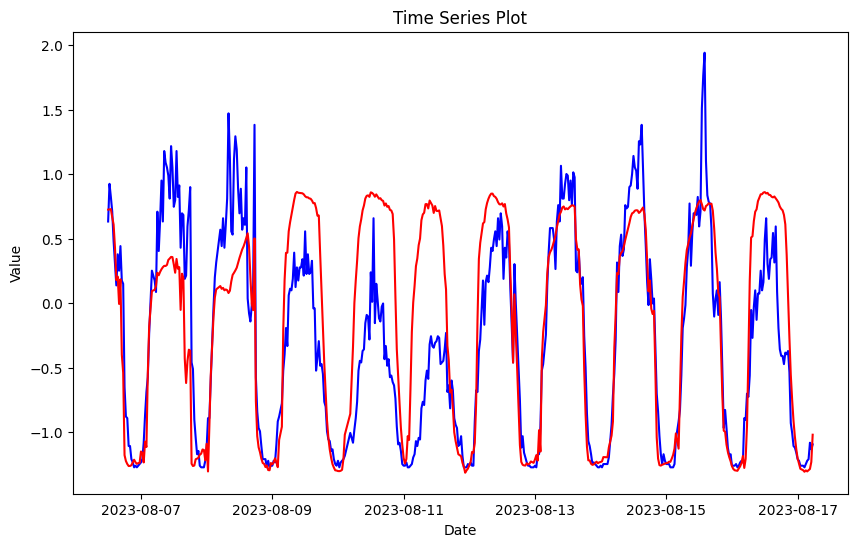

In [274]:


# Plotting
